In [2]:
import xarray as xr
import glob

# Step 1: Define directory path
grib_dir = "data/2m_Temp/"

# Step 2: Get all GRIB files in the directory
grib_files = sorted(glob.glob(grib_dir + "*.grib"))

# Step 3: Debugging print statements
print("Found GRIB files:", grib_files)

# Step 4: Open files and check time dimension
ds_list = []
for file in grib_files:
    try:
        ds = xr.open_dataset(file, engine="cfgrib", chunks={'time': 100})
        if "time" not in ds.dims:
            print(f"Warning: 'time' dimension missing in {file}. Available dims:", ds.dims)
        else:
            ds_list.append(ds)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Step 5: Merge datasets if any were successfully opened
if ds_list:
    merged_ds = xr.concat(ds_list, dim="time", combine_attrs="override")
    print("Merged dataset is ready.")
else:
    print("No valid datasets found. Check file paths and content.")


Found GRIB files: ['data/2m_Temp\\t_1990-99.grib', 'data/2m_Temp\\t_2000-12.grib', 'data/2m_Temp\\t_2013-25.grib']


G:\New folder\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
G:\New folder\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Merged dataset is ready.


G:\New folder\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [16]:
import numpy as np
import pandas as pd 
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd 
import xarray as xr  
from shapely.geometry import box

ds=merged_ds
print(ds)

<xarray.Dataset> Size: 203MB
Dimensions:     (time: 308767, latitude: 32, longitude: 5)
Coordinates:
    number      int32 4B 0
  * time        (time) datetime64[ns] 2MB 1990-01-01 ... 2025-03-23T06:00:00
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0
  * latitude    (latitude) float64 256B 7.05 6.8 6.55 6.3 ... -0.2 -0.45 -0.7
  * longitude   (longitude) float64 40B 72.54 72.79 73.04 73.29 73.54
    valid_time  (time) datetime64[ns] 2MB dask.array<chunksize=(100,), meta=np.ndarray>
Data variables:
    t2m         (time, latitude, longitude) float32 198MB dask.array<chunksize=(100, 32, 5), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T16:47 GRIB to 

In [17]:
ds.variables

Frozen({'t2m': <xarray.Variable (time: 308767, latitude: 32, longitude: 5)> Size: 198MB
dask.array<concatenate, shape=(308767, 32, 5), dtype=float32, chunksize=(100, 32, 5), chunktype=numpy.ndarray>
Attributes: (12/31)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           2t
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown, 'number': <xarray.Variable ()> Size: 4B
array(0)
Attributes:
    long_name:      ensemble member numerical id
  

In [18]:
ds.t2m

<xarray.DataArray 't2m' (time: 308767, latitude: 32, longitude: 5)> Size: 198MB
dask.array<concatenate, shape=(308767, 32, 5), dtype=float32, chunksize=(100, 32, 5), chunktype=numpy.ndarray>
Coordinates:
    number      int32 4B 0
  * time        (time) datetime64[ns] 2MB 1990-01-01 ... 2025-03-23T06:00:00
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0
  * latitude    (latitude) float64 256B 7.05 6.8 6.55 6.3 ... -0.2 -0.45 -0.7
  * longitude   (longitude) float64 40B 72.54 72.79 73.04 73.29 73.54
    valid_time  (time) datetime64[ns] 2MB dask.array<chunksize=(100,), meta=np.ndarray>
Attributes: (12/31)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           2t
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown

In [19]:
lon = ds.t2m.longitude
lat = ds['t2m'].latitude
da = ds.where(ds.t2m != -999.) #Remove NaN values

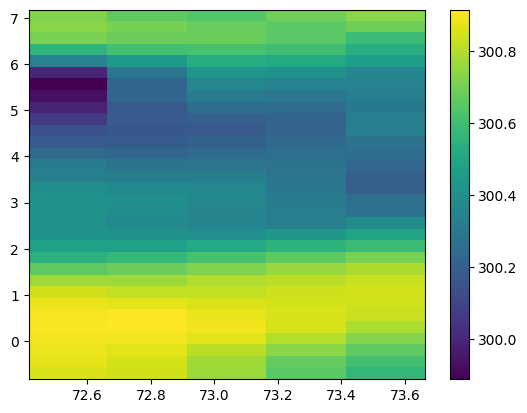

In [20]:
plt.figure()
plt.pcolor(lon, lat, ds.t2m[255, :, :],
          #  vmax= 20,
          #  vmin = 0,
          #  cmap = "Blues"
           );
plt.colorbar()

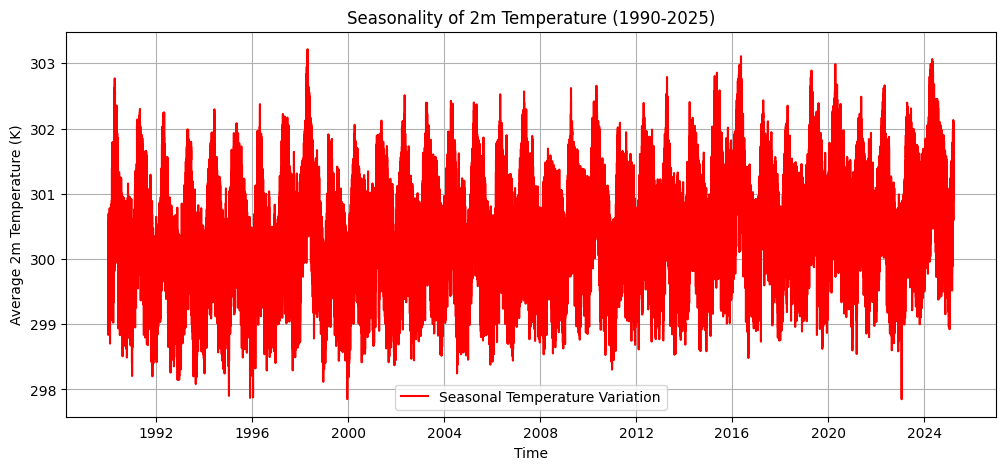

In [21]:
#Seasonality with daily average

time = ds.valid_time
t2m = ds.t2m

# Compute the area-averaged temperature (mean over latitude and longitude)
t2m_mean = t2m.mean(dim=["latitude", "longitude"])

# Convert time to datetime format (if needed)
time = xr.decode_cf(ds).valid_time  # Ensure proper datetime handling

# Plot the seasonality of temperature variation
plt.figure(figsize=(12, 5))
plt.plot(time, t2m_mean, label="Seasonal Temperature Variation", color='r')

# Formatting the plot
plt.xlabel("Time")
plt.ylabel("Average 2m Temperature (K)")
plt.title("Seasonality of 2m Temperature (1990-2025)")
plt.legend()
plt.grid()

# Show the plot
plt.show()

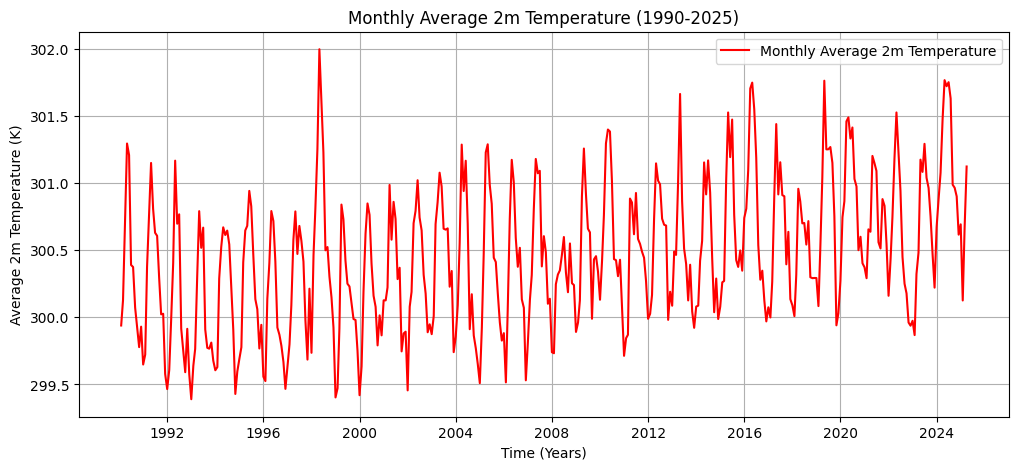

In [23]:
#Monthly average

t2m_mean = ds.t2m.mean(dim=["latitude", "longitude"])

# Resample to get the monthly average
t2m_monthly = t2m_mean.resample(valid_time="ME").mean()

# Plot the seasonality (monthly averaged temperature variation)
plt.figure(figsize=(12, 5))
plt.plot(t2m_monthly.valid_time, t2m_monthly, label="Monthly Average 2m Temperature", color='r')

# Formatting the plot
plt.xlabel("Time (Years)")
plt.ylabel("Average 2m Temperature (K)")
plt.title("Monthly Average 2m Temperature (1990-2025)")
plt.legend()
plt.grid()

# Show the plot
plt.show()

<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


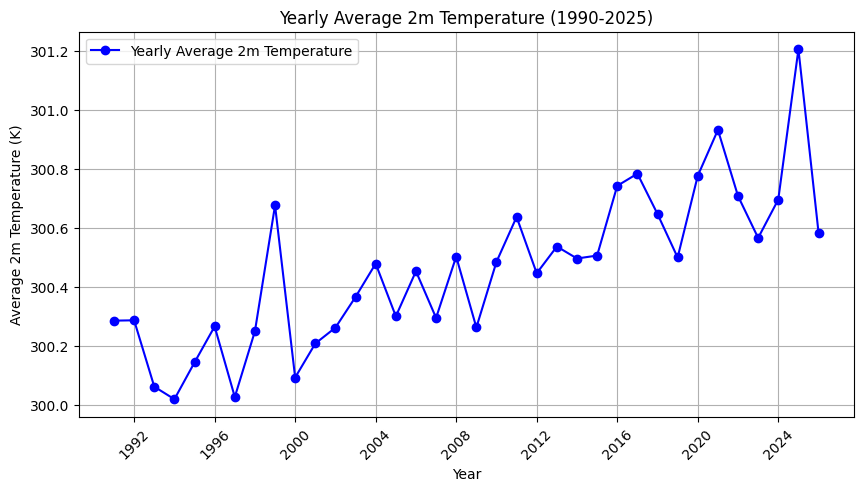

In [24]:
#YEARLY 

t2m_yearly = t2m_mean.resample(valid_time="Y").mean()

# Plot yearly average temperature variation
plt.figure(figsize=(10, 5))
plt.plot(t2m_yearly.valid_time, t2m_yearly, marker='o', linestyle='-', color='b', label="Yearly Average 2m Temperature")

# Formatting the plot
plt.xlabel("Year")
plt.ylabel("Average 2m Temperature (K)")
plt.title("Yearly Average 2m Temperature (1990-2025)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Show the plot
plt.show()

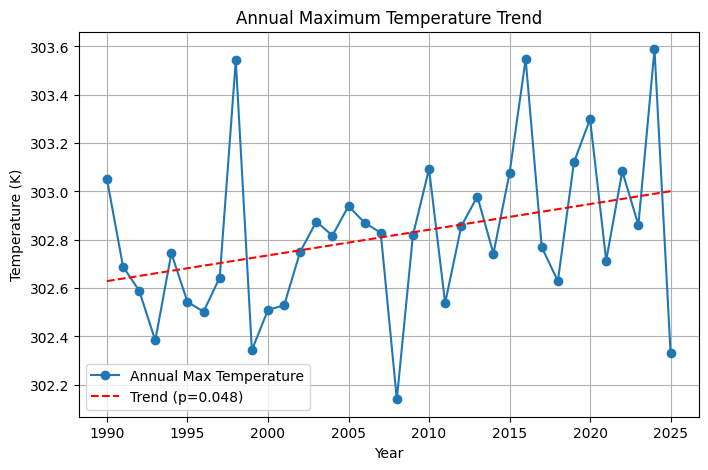

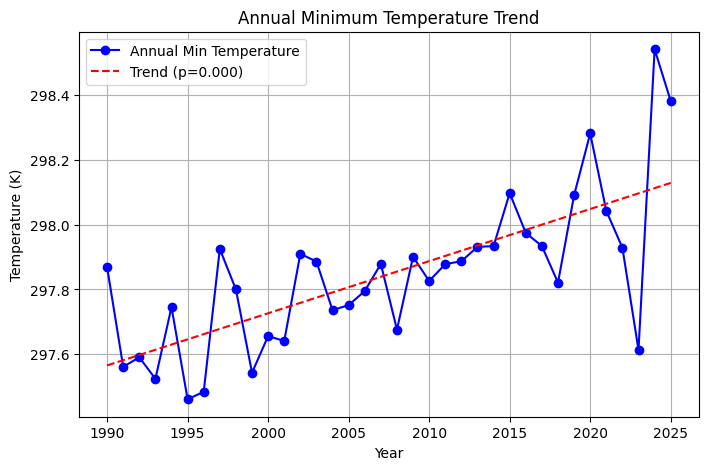

In [25]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress



# Ensure 'time' is a proper datetime object
ds["time"] = xr.decode_cf(ds)["time"]

# Extract the year from the time dimension
ds = ds.assign_coords(year=ds["time"].dt.year)

# Compute annual max and min temperature (spatially averaged)
annual_max_temp = ds.t2m.groupby("year").max(dim="time").mean(dim=["latitude", "longitude"])
annual_min_temp = ds.t2m.groupby("year").min(dim="time").mean(dim=["latitude", "longitude"])

# Perform linear regression for trends
slope_max, intercept_max, r_value_max, p_value_max, std_err_max = linregress(annual_max_temp.year, annual_max_temp)
slope_min, intercept_min, r_value_min, p_value_min, std_err_min = linregress(annual_min_temp.year, annual_min_temp)

# Plot the trend for max temperature
plt.figure(figsize=(8,5))
plt.plot(annual_max_temp.year, annual_max_temp, marker='o', linestyle='-', label="Annual Max Temperature")
plt.plot(annual_max_temp.year, slope_max * annual_max_temp.year + intercept_max, linestyle="dashed", color="red", label=f"Trend (p={p_value_max:.3f})")
plt.xlabel("Year")
plt.ylabel("Temperature (K)")
plt.title("Annual Maximum Temperature Trend")
plt.legend()
plt.grid()
plt.show()

# Plot the trend for min temperature
plt.figure(figsize=(8,5))
plt.plot(annual_min_temp.year, annual_min_temp, marker='o', linestyle='-', label="Annual Min Temperature", color="blue")
plt.plot(annual_min_temp.year, slope_min * annual_min_temp.year + intercept_min, linestyle="dashed", color="red", label=f"Trend (p={p_value_min:.3f})")
plt.xlabel("Year")
plt.ylabel("Temperature (K)")
plt.title("Annual Minimum Temperature Trend")
plt.legend()
plt.grid()
plt.show()


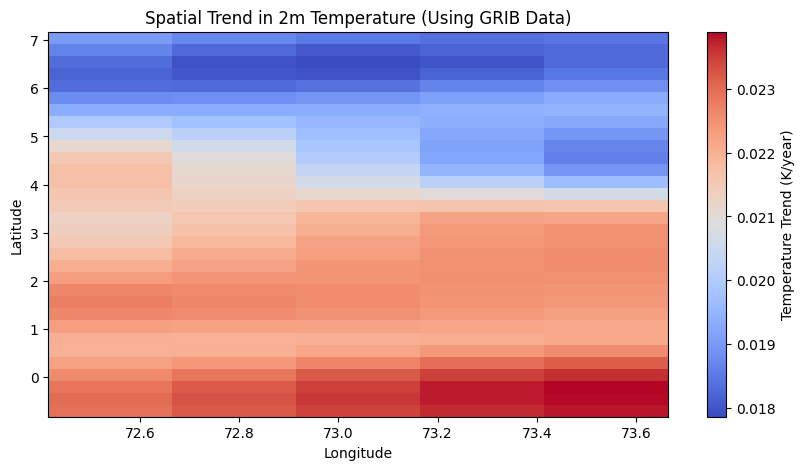

In [28]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import linregress


# Extract variables
t2m = ds["t2m"].values  # Temperature at 2m height (time, lat, lon)
time = ds["time"].values  # Time array
lat = ds["latitude"].values
lon = ds["longitude"].values

# Convert time to years
years = np.array([pd.Timestamp(t).year for t in time])

# Prepare array for storing slopes (temperature trend at each grid point)
trend_map = np.full((len(lat), len(lon)), np.nan)

# Compute trends for each grid cell
for i in range(len(lat)):
    for j in range(len(lon)):
        temp_series = t2m[:, i, j]  # Time series for one grid cell
        
        if np.all(np.isnan(temp_series)):  # Skip if all values are NaN
            continue
        
        slope, _, _, p_value, _ = linregress(years, temp_series)
        
        # Only consider significant trends (p-value < 0.05)
        if p_value < 0.05:
            trend_map[i, j] = slope

# Plot the trend map
plt.figure(figsize=(10, 5))
plt.pcolormesh(lon, lat, trend_map, cmap="coolwarm", shading="auto")
plt.colorbar(label="Temperature Trend (K/year)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Trend in 2m Temperature (Using GRIB Data)")
plt.show()


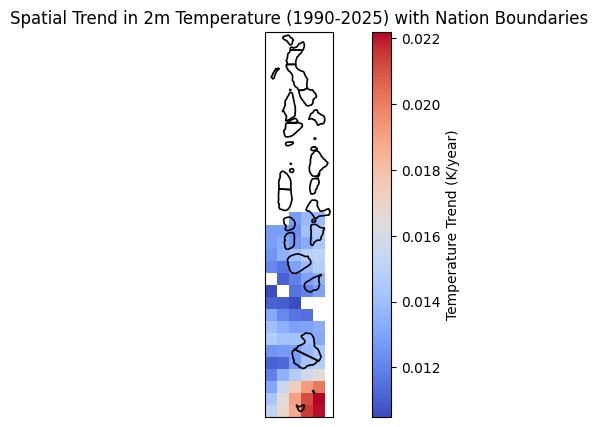

In [36]:
#plotting Nation boundaries using shapefile. 
# We are doing this separately since the libraries dont provide correct nation boundary for India

import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the shapefile for national boundaries
shapefile_path = r"data/maldives_admin_division.shp"
gdf = gpd.read_file(shapefile_path)  # Read the shapefile

# Plot the trend map with nation boundaries
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot temperature trend map
trend_plot = ax.pcolormesh(lon, lat, trend_map, cmap="coolwarm", shading="auto", transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(trend_plot, ax=ax, orientation="vertical", label="Temperature Trend (K/year)")

# Plot the shapefile as nation boundaries
gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.2, transform=ccrs.PlateCarree())

# Labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Spatial Trend in 2m Temperature (1990-2025) with Nation Boundaries")

# Show plot
plt.show()


Text(0.5, 1.0, 'Spatial Trend in 2m Temperature (1990-2025)')

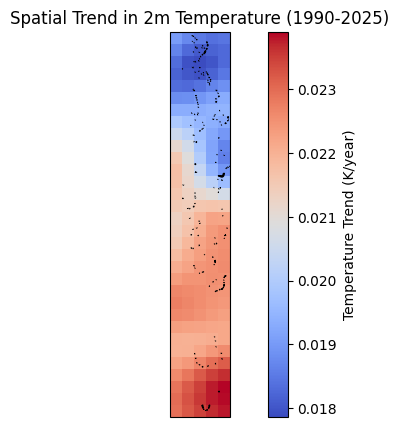

In [32]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress


# Extract temperature data (t2m) and coordinates
t2m = ds["t2m"].values  # Shape: (time, lat, lon)
lat = ds["latitude"].values
lon = ds["longitude"].values
time = ds["time"].values  # Already in numpy.datetime64 format

# Convert time values to years correctly
years = np.array([int(str(t)[:4]) for t in time])

# Initialize an array for storing trends
trend_map = np.full((len(lat), len(lon)), np.nan)

# Loop through each grid cell to calculate temperature trends
for i in range(len(lat)):
    for j in range(len(lon)):
        temp_series = t2m[:, i, j]

        # Skip if all values are NaN
        if np.all(np.isnan(temp_series)):
            continue

        # Compute linear trend
        slope, _, _, p_value, _ = linregress(years, temp_series)

        # Store only significant trends
        if p_value < 0.05:
            trend_map[i, j] = slope  # Temperature trend (K/year)

# Plot the temperature trend map
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()})

# Display the trend data
trend_plot = ax.pcolormesh(lon, lat, trend_map, cmap="coolwarm", shading="auto", transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(trend_plot, ax=ax, orientation="vertical", label="Temperature Trend (K/year)")

# Add borders and coastlines
ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor="black")
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor="black")

# Labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Spatial Trend in 2m Temperature (1990-2025)")

Text(0.5, 1.0, 'Spatial Trend in Annual Maximum Temperature (1990-2025)')

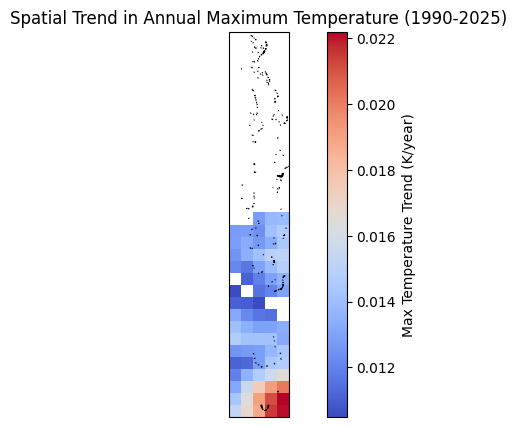

In [38]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress


# Extract variables
t2m = ds["t2m"].values  # Shape: (time, lat, lon)
lat = ds["latitude"].values
lon = ds["longitude"].values
time = ds["time"].values  # Time in numpy.datetime64 format

# Convert time to years properly
years = np.array([int(str(t)[:4]) for t in time])  # Extract year from datetime64

# Find unique years
unique_years = np.unique(years)

# Create an array to store annual max temperatures
annual_max_temps = np.full((len(unique_years), len(lat), len(lon)), np.nan)

# Compute annual max temperature for each grid cell
for i, year in enumerate(unique_years):
    year_mask = years == year
    if np.any(year_mask):  # Ensure there's data for this year
        annual_max_temps[i] = np.nanmax(t2m[year_mask], axis=0)

# Create an empty array to store temperature trend values
trend_map = np.full((len(lat), len(lon)), np.nan)

# Compute trends for each grid cell
for i in range(len(lat)):
    for j in range(len(lon)):
        temp_series = annual_max_temps[:, i, j]  # Time series for this grid cell

        if np.all(np.isnan(temp_series)):  # Skip NaN values
            continue

        slope, _, _, p_value, _ = linregress(unique_years, temp_series)

        if p_value < 0.05:  # Store only significant trends
            trend_map[i, j] = slope

# Plot the trend map
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()})
trend_plot = ax.pcolormesh(lon, lat, trend_map, cmap="coolwarm", shading="auto", transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(trend_plot, ax=ax, orientation="vertical", label="Max Temperature Trend (K/year)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor="black")
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor="black")

# Labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Spatial Trend in Annual Maximum Temperature (1990-2025)")
